In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from numpy.polynomial.hermite import Hermite

Loss 
$$L(W_2) = \frac{1}{m}||Y - W_2^T F||_F^2 + \frac{\gamma}{n2}||W_2||_F^2$$
where $F = f(WX)$

Optimal $W_2$ 
$$W_2^* =(1/m)FQY^T$$
where 
$$Q = ((1/m)F^TF + \gamma I_m)^{-1}$$


f can be expanded as a Hermite polynomial, i.e.
$$f(x) = \sum_{i=0}^{d} f_i H_i(x)$$
where $H_i(x)$ is the $i$th Hermite polynomial.

The ith Hermite polynomial is defined as
$$H_i(x) = (-1)^i e^{x^2/2} \frac{d^i}{dx^i} e^{-x^2/2}$$

Authors showed that there is a convenient to sample $f$ based on $\zeta$ and $\eta$ by letting $\sqrt{\zeta} = f_1$ and $\sum_i^N f_i^2 = \eta - 1$.


In [2]:
def sample_fixed_norm_vector(d, eta):
    f = np.random.normal(0, 1, d)
    f /= np.linalg.norm(f)
    f *= np.sqrt(eta - 1)
    return f

def f(x,zeta,eta,d):
    coeffs = [np.sqrt(zeta)]
    f_coeffs = sample_fixed_norm_vector(d,eta)
    coeffs.extend(f_coeffs)
    return np.polynomial.hermite.Hermite(coeffs)(x)
    
def build_W(n0, n1, sigma_w, seed=None):
    rng = np.random.default_rng(seed=seed)
    return (sigma_w / np.sqrt(n0)) * rng.standard_normal(size=(n1, n0))

def loss(m,gamma,Y,F,W2):
    l = (1/m)*np.linalg.norm(Y - np.matmul(W2.T,F))**2 + gamma * np.linalg.norm(W2)**2
    return l

def accuracy(Y_true,Y_pred):
    return np.sum(Y_true == Y_pred)/len(Y_true)

In [3]:
mnist = fetch_openml("mnist_784", parser="auto")
X = np.array(mnist.data) / 255.0 
y = np.array(mnist.target).astype(int)

from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

# fitting scalar and pca to entire training set 
scaler = StandardScaler()
pca = PCA(n_components=0.95)
centered_train_X = scaler.fit_transform(X)
pca.fit(centered_train_X)

# Get indices where y is either 3 or 8
indices = np.where((y == 3) | (y == 8))[0]

# Filter X and y using these indices
X_filtered = X[indices]
y_filtered = y[indices]

centered_X_filered = scaler.transform(X_filtered)
X_train = pca.transform(centered_X_filered)

lb = LabelBinarizer(neg_label=-1,pos_label=1)
y_train = lb.fit_transform(y_filtered).squeeze()

In [4]:
m = X_train.shape[0]
n0 = X_train.shape[1]
phi = n0/m
psi = 1
n1 = int(n0 / psi)
sigma_w = 1

The authors show that when $\zeta$ is closed to $\eta$, the models are unable to
utilize their nonlinearity unless the $\gamma$ is small. Conversely,
for $\zeta$ close to zero, the models exploits the nonlinearity and absorb large
amounts of regularization without a significant drop in performance. 

In [5]:
# Choose a fixed value for η 
eta = 2.0

beta_log_ratio_values = np.logspace(-100, 3, 10)

# Calculate corresponding ζ values
zeta_values = eta / (10**(beta_log_ratio_values) + 1)

gamma_log_ratio_values = np.linspace(3, 3, 10)
gamma_values = eta * (10**gamma_log_ratio_values)

/var/folders/wq/syx9m2g570sg5zryv4kqc1xr0000gn/T/ipykernel_89934/1376258337.py:7: RuntimeWarning: overflow encountered in power
  zeta_values = eta / (10**(beta_log_ratio_values) + 1)


In [ ]:
l_avg = np.zeros((len(zeta_values),len(gamma_values)))
for i,zeta in enumerate(zeta_values):
    for j,gamma in enumerate(gamma_values):
        l = []
        for k in range(1):
            W = build_W(n0, n1, sigma_w)
            F = f(np.matmul(W,X_train.T),zeta,eta,100)
            Q = np.linalg.inv((1/m)*np.matmul(F.T,F) + gamma * np.identity(m))
            W2 = (1/m)*np.matmul(np.matmul(F,Q),y_train.T)
            y_pred = np.sign(np.matmul(W2.T,F))     
            l.append(accuracy(y_train,y_pred))
        l_avg[i,j] = np.mean(l)

/var/folders/wq/syx9m2g570sg5zryv4kqc1xr0000gn/T/ipykernel_89934/2206164562.py:8: RuntimeWarning: overflow encountered in matmul
  Q = np.linalg.inv((1/m)*np.matmul(F.T,F) + gamma * np.identity(m))
/var/folders/wq/syx9m2g570sg5zryv4kqc1xr0000gn/T/ipykernel_89934/2206164562.py:8: RuntimeWarning: invalid value encountered in matmul
  Q = np.linalg.inv((1/m)*np.matmul(F.T,F) + gamma * np.identity(m))


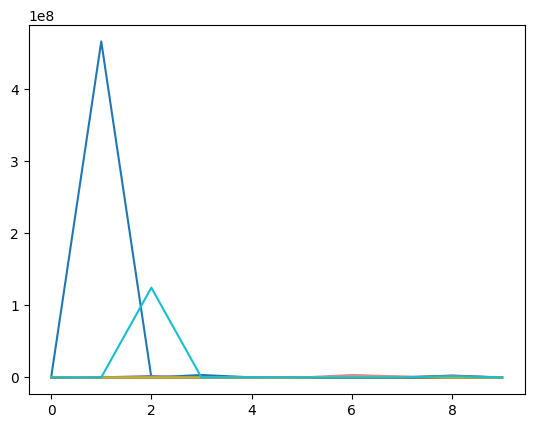

In [ ]:
for i in range(l_avg.shape[0]):
    plt.plot(l_avg[i])